Student Name: Yuhang Peng <br>
Student ID:   34278818

# 3 Logistic Regression versus Bayes Classifier

## Question 5

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, zero_one_loss
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

### I

Bayes' theorem is used to compute the posterior probability $p(c_k|x)$, given the class conditional probability and the class priors:
$$
p(c_k|x) = \frac{p(x|c_k)p(c_k)}{\sum_{l=1}^{K} p(x|c_l)p(c_l)}
$$
Where:
- $p(c_k|x)$ is the posterior probability of class $c_k$ given the input $x$.
- $p(x|c_k)$ is the class conditional probability density function for class $c_k$.
- $p(c_k)$ is the prior probability of class $c_k$.
- $\sum_{l=1}^{K} p(x|c_l)p(c_l)$ is the marginal likelihood, summing over all classes.

For the class conditional probability $p(x|c_k)$, we assume it follows a multivariate normal (Gaussian) distribution:
$$
p(x|c_k) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_k|}} \exp\left( -\frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) \right)
$$
Where:
- $\mu_k$ is the mean vector of class $c_k$.
- $\Sigma_k$ is the covariance matrix of class $c_k$.
- $d$ is the dimensionality of the feature space (number of features).
- $|\Sigma_k|$ is the determinant of the covariance matrix $\Sigma_k$.
- $(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)$ is the Mahalanobis distance between the data point $x$ and the mean $\mu_k$.

The prior probability $p(c_k)$ of class $c_k$ is calculated as the proportion of data points that belong to class $c_k$ in the training set:
$$
p(c_k) = \frac{N_k}{N}
$$
Where:
- $N_k$ is the number of data points in class $c_k$.
- $N$ is the total number of data points in the training set.

The marginal probability $p(x)$ is obtained by summing the weighted class conditional probabilities:
$$
p(x) = \sum_{l=1}^{K} p(x|c_l)p(c_l)
$$
Where:
- $p(x|c_l)$ is the conditional probability of $x$ given class $c_l$.
- $p(c_l)$ is the prior probability of class $c_l$.
- $K$ is the total number of classes.

In [6]:
class BayesianClassifier:
    
    def __init__(self, shared_cov=True, cond_ind=True):
        """
        Initializes the BayesianClassifier with options for shared covariance
        and conditional independence assumptions.

        Parameters:
        shared_cov: If True, assumes all classes share the same covariance matrix.
        cond_ind: If True, assumes conditional independence (diagonal covariance matrix).
        """
        self.shared_cov = shared_cov
        self.cond_ind = cond_ind

    def fit(self, x, y):
        """
        Fits the model by estimating class priors, means, and covariance matrices.

        Parameters:
        x: Input features of shape (n_samples, n_features).
        y: Class labels of shape (n_samples,).

        Returns:
        self: Trained model instance.
        """
        # Get unique classes and their counts
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_, self.p_ = x.shape
        self.k_ = len(self.classes_)

        # Initialize arrays to store conditional means and covariance matrices
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))

        # Estimate class priors 
        self.class_priors_ = class_counts / len(y)

        for c in range(self.k_):
            # Extract rows corresponding to class 'c'
            c_rows = y == c

            # Compute conditional means for class 'c'
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)

            # Estimate covariance matrix
            if self.cond_ind:
                # Diagonal covariance matrix (Naive Bayes assumption)
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                # Full covariance matrix
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        # If shared covariance is assumed, compute the weighted average covariance 
        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        """
        Predict the posterior probabilities for each class given the input data.

        Parameters:
        x: Input data of shape (n_samples, n_features).

        Returns:
        probs: Posterior probabilities of shape (n_samples, n_classes).
        """
        m, _ = x.shape

        # Initialize array to store conditional probabilities
        cond_probs = np.zeros(shape=(m, self.k_))

        for c in range(self.k_):
            # Compute p(x|c) for each class using multivariate normal distribution 
            cond_probs[:, c] = multivariate_normal.pdf(
                x,
                self.cond_means_[c],
                self.cond_covs_[c],
                allow_singular=True
            )

        # Compute marginal probabilities p(x) by summing over the conditionals
        marginal_probs = cond_probs.dot(self.class_priors_)

        # Compute posterior probabilities p(c|x) using Bayes' rule
        probs = np.divide(
            (cond_probs * self.class_priors_).T,
            marginal_probs,
            where=marginal_probs > 0,
            out=np.zeros(shape=(self.k_, m))
        ).T

        # Clip probabilities to avoid values becoming zero
        probs = np.clip(probs, 1e-16, None)
    
        # Normalize the probabilities to ensure they sum to 1 across classes
        probs = probs / probs.sum(axis=1, keepdims=True)
    
        return probs

    def predict(self, x):
        """
        Predicts the class labels for the input data.

        Parameters:
        x: Input data of shape (n_samples, n_features).

        Returns:
        predictions: Predicted class labels of shape (n_samples,).
        """
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        """
        Computes the decision function, returning the log odds ratio for binary classification.

        Parameters:
        x: Input data of shape (n_samples, n_features).

        Returns:
        decision_values: Log odds ratio or log posterior odds.
        """
        probs = self.predict_proba(x)

        if self.k_ == 2:
            # Binary classification: log odds ratio
            return np.log(probs[:, 1] / probs[:, 0])
        else:
            # Multi-class classification: return log-probabilities for each class
            res = np.zeros((len(x), self.k_))
            for c in range(self.k_):
                res[:, c] = np.log(probs[:, c] / (1 - probs[:, c]))
            return res

    def generate(self, n, c, random_state=None):
        """
        Generates synthetic data for a given class based on the learned distribution.

        Parameters:
        n: Number of samples to generate.
        c: Class label for which to generate samples.
        random_state: Random seed.

        Returns:
        generated_data: Generated data of shape (n_samples, n_features).
        """
        return multivariate_normal.rvs(
            self.cond_means_[c],
            self.cond_covs_[c],
            size=n,
            random_state=random_state
        )

Log loss, also known as logarithmic loss or cross-entropy loss, measures the performance of a classification model whose output is a probability between 0 and 1. It penalizes predictions that deviate from the true class label, especially when the predicted probability is far from the actual label.

Formula:
$$
\text{Log Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

Zero one loss measures the proportion of incorrect predictions. It's a simple metric that gives 1 for every incorrect prediction and 0 for correct ones. It is also referred to as the 0/1 loss or misclassification error.

Formula:
$$
\text{0/1 Loss} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\hat{y}_i \neq y_i)
$$

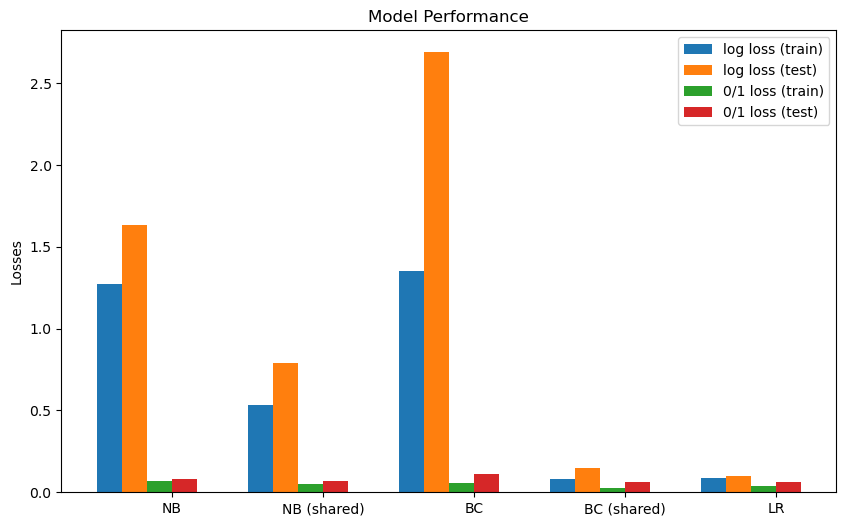

In [7]:
# Load the breast cancer dataset
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Define a function to plot model performances based on both log loss and 0/1 loss for train and test data
def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    # Lists to store the losses for each model
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    # Loop over each model to calculate performance metrics
    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.fit(X_train, y_train).predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.fit(X_train, y_train).predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.fit(X_train, y_train).predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.fit(X_train, y_train).predict_proba(x_test)))

    # Create an array of indices for the number of models to position bars
    xx = np.arange(len(models))

    # Define the width of each bar in the plot based on the number of models
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width

    # Create bar plots for each metric for both training and testing sets
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')

    # Set the labels on the x-axis as the model names
    plt.xticks(xx, model_names)

# Train Bayesian Classifier models with different variants
def initialize_models():
    # 1. Naive Bayes (with diagonal covariance matrix, cond_ind=True)
    nb = BayesianClassifier(shared_cov=False, cond_ind=True)
    
    # 2. Naive Bayes with shared covariance (with diagonal covariance matrix, cond_ind=True)
    nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True)
    
    # 3. Bayesian Classifier with full covariance (not shared, cond_ind=False)
    bc = BayesianClassifier(shared_cov=False, cond_ind=False)
    
    # 4. Bayesian Classifier with shared covariance (full covariance, shared across classes, cond_ind=False)
    bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False)
    
    # Logistic Regression model
    lr = LogisticRegression(max_iter=10000)

    # Define the models
    models = [nb, nb_shared, bc, bc_shared, lr]

    return models

models = initialize_models()

# Define the model names
model_names = ['NB', 'NB (shared)', 'BC', 'BC (shared)', 'LR']

# Plot the model performance
plt.figure(figsize=(10, 6))
plot_model_performances(models, model_names, X_train, y_train, X_test, y_test)
plt.legend()
plt.title('Model Performance')
plt.ylabel('Losses')
plt.show()

Bayesian Classifier (Shared Full Covariance) and Logistic Regression perform the best in terms of both log loss and 0/1 loss, for both training and testing.

### II

In [27]:
def run_experiment(models, model_names, X, y, train_sizes=np.arange(5, 501, 5), repeats=10):
    """
    Run an experiment to test the performance of models for increasing training sizes
    and records training and test errors (log loss and 0/1 loss).

    Parameters:
    models: List of models to evaluate.
    model_names: List of model names corresponding to the models.
    X: Feature matrix.
    y: Target vector.
    train_sizes: Array of training sizes.
    repeats: Number of repeats for each training size.
    """
    # Initialize a dictionary to store the results for each model
    results = {name: {'train_log_loss': [], 'test_log_loss': [], 'train_01_loss': [], 'test_01_loss': []}
               for name in model_names}

    # Add train sizes to the results dictionary
    results['train_sizes'] = train_sizes

    # Loop over each training size
    for N in train_sizes:
        # Initialize the lists to store the results for each repeat
        for name in model_names:
            results[name]['train_log_loss'].append([])  # Add an empty list for each repeat
            results[name]['test_log_loss'].append([])
            results[name]['train_01_loss'].append([])
            results[name]['test_01_loss'].append([])

        # Repeat experiment for each training size N
        for _ in range(repeats):
            # Split the data into training and testing sets with specified training size N
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N, stratify=y, shuffle=True)

            # Loop through each model
            for model, name in zip(models, model_names):
                # Train the model on the training set
                model.fit(X_train, y_train)
                
                # Calculate predictions and probabilities for training and test sets
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
                y_train_proba = model.predict_proba(X_train)
                y_test_proba = model.predict_proba(X_test)
                
                # Calculate and store log loss and 0/1 loss for training and test sets
                results[name]['train_log_loss'][-1].append(log_loss(y_train, y_train_proba))
                results[name]['test_log_loss'][-1].append(log_loss(y_test, y_test_proba))
                results[name]['train_01_loss'][-1].append(zero_one_loss(y_train, y_train_pred))
                results[name]['test_01_loss'][-1].append(zero_one_loss(y_test, y_test_pred))
    
    return results

In [28]:
models = initialize_models()
model_names = ['NB', 'NB (shared)', 'BC', 'BC (shared)', 'LR']
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target
results = run_experiment(models, model_names, X, y, train_sizes=np.arange(5, 501, 5), repeats=10)

### III

In [58]:
def plot_experiment_results(results, model_names):
    """
    Visualize the average log loss and 0/1 loss for each model over different training sizes.
    
    Parameters:
    results: Dictionary containing performance metrics (log loss, 0/1 loss).
    model_names: List of model names corresponding to the models.
    """
    train_sizes = results['train_sizes']

    # Create a figure with 5 rows and 2 columns (10 subplots in total)
    fig, axs = plt.subplots(5, 2, figsize=(20, 30))

    # Loop over models and plot log loss and 0/1 loss in separate subplots
    for i, name in enumerate(model_names):
        # Compute the mean log loss (train and test)
        mean_train_log_loss = np.mean(results[name]['train_log_loss'], axis=1)
        mean_test_log_loss = np.mean(results[name]['test_log_loss'], axis=1)

        # Plot log loss for both train and test sets without error bars
        axs[i, 0].plot(train_sizes, mean_train_log_loss, label=f'{name} Log Loss (Train)')
        axs[i, 0].plot(train_sizes, mean_test_log_loss, label=f'{name} Log Loss (Test)')
        axs[i, 0].set_title(f'{name} Log Loss vs Training Size')
        axs[i, 0].set_xlabel('Training Size')
        axs[i, 0].set_ylabel('Log Loss')
        axs[i, 0].set_xlim(0, 500) 
        axs[i, 0].legend()

        # Compute the mean 0/1 loss (train and test)
        mean_train_01_loss = np.mean(results[name]['train_01_loss'], axis=1)
        mean_test_01_loss = np.mean(results[name]['test_01_loss'], axis=1)

        # Plot 0/1 loss for both train and test sets without error bars
        axs[i, 1].plot(train_sizes, mean_train_01_loss, label=f'{name} 0/1 Loss (Train)')
        axs[i, 1].plot(train_sizes, mean_test_01_loss, label=f'{name} 0/1 Loss (Test)')
        axs[i, 1].set_title(f'{name} 0/1 Loss vs Training Size')
        axs[i, 1].set_xlabel('Training Size')
        axs[i, 1].set_ylabel('0/1 Loss')
        axs[i, 1].set_xlim(0, 500)  
        axs[i, 1].legend()

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

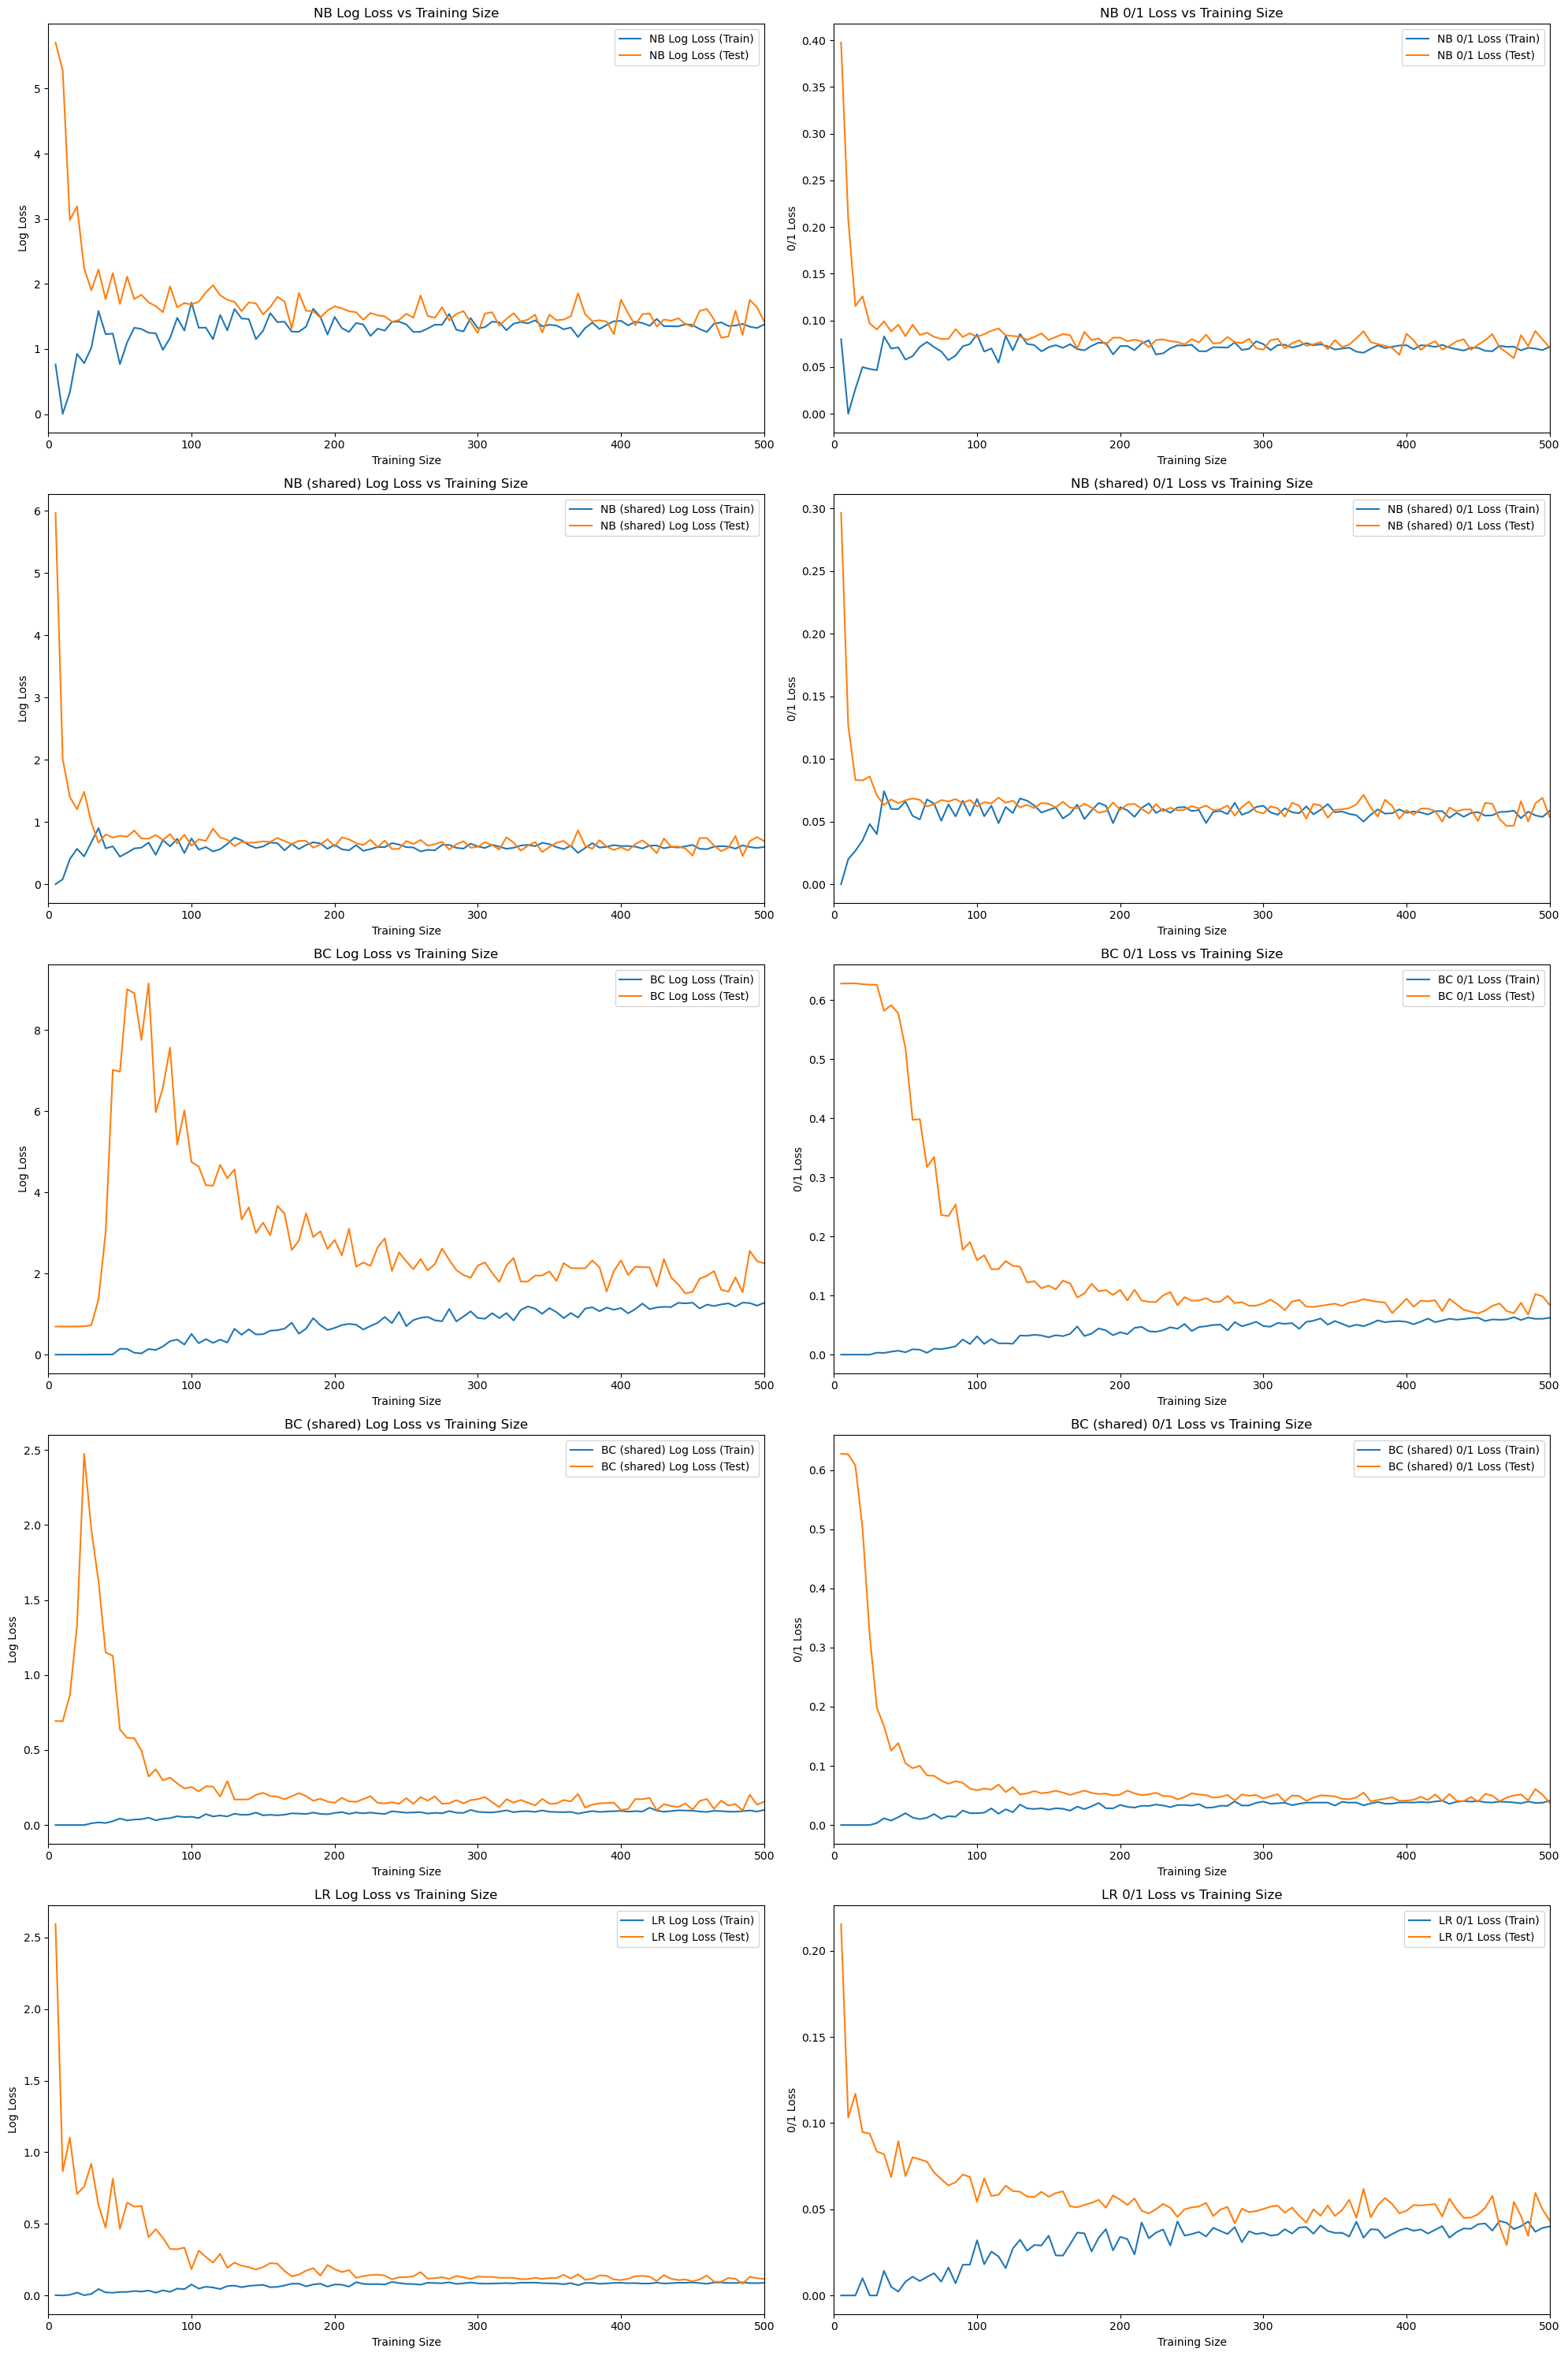

In [59]:
plot_experiment_results(results, model_names)

### IV

#### a

What happens to each classifiers train and test performance when the number of training data points is increased?

1. Naive Bayes (NB and NB shared)
   - Naive Bayes shows a decreasing trend in both metrics as the training size increases. The training loss becomes more stable and decreases to a certain level, suggesting that the model is improving as more data is available.
   - The test loss also decreases as the training size grows, indicating better generalization with larger data. However, the test log loss starts higher, suggesting some initial overfitting.
  
2. Bayesian Classifier (BC and BC shared):
   - The log loss and 0/1 loss on the training set are lower, but there is more fluctuation with smaller datasets.  As the dataset size increases, the performance stabilizes. BC models show more variance, suggesting sensitivity to the data size.
   - The test loss initially shows higher values but stabilizes with larger datasets, indicating that the model starts to generalize better with more data. However, the test performance shows that the model is more prone to overfitting when the training set is small.
  
3. Logistic Regression (LR):
   - Logistic regression performs quite well on the training set with increasing data. The train loss stabilizes as the number of training points increases, and the train 0/1 loss becomes very low with sufficient data.
   - Test loss starts higher but decreases steadily as the training set increases, eventually converging to low loss values. This suggests that logistic regression requires a larger dataset to perform well on unseen data.

#### b

Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

Best suited for small training sets:
- Naive Bayes (NB): This model is simpler and relies on strong assumptions (e.g., independence of features). It tends to perform better on small datasets compared to more complex models like BC. From the visualizations, NB shows lower variance and better performance than BC with smaller datasets.
- NB (shared) also performs relatively well in smaller datasets because its simplified assumptions are not prone to overfitting on limited data.

Best suited for large training sets:
- Logistic Regression (LR): For larger training sets, logistic regression consistently achieves lower test loss (both log loss and 0/1 loss) compared to Naive Bayes and BC. Its test loss decreases steadily with larger datasets, indicating it benefits more from larger datasets.
- Bayesian Classifier (BC and BC shared) also improves with more data, but logistic regression achieves better generalization performance in this case.

#### c

Justify your observations by providing some speculations and possible reasons.

1. Naive Bayes
   - Naive Bayes performs well with smaller datasets because it has fewer parameters to estimate and relies on strong simplifying assumptions (e.g., conditional independence of features). This makes it less prone to overfitting and more stable when the data is scarce.
   - Although Naive Bayes improves with more data, its simplifying assumptions may become a limiting factor. As the dataset size increases, the model's assumptions may fail to capture the true relationships in the data, which is why more complex models outperform it with larger datasets.
  
2. Bayesian Classifier (BC)
   - BC is more complex than Naive Bayes and thus needs more data to estimate its parameters effectively. It is prone to overfitting with small datasets, as indicated by the high test losses early on. As more data becomes available, BC starts to perform better, but its higher complexity makes it less stable on small datasets.
   - BC seems to suffer more from overfitting when the training set is small, as seen from the significant gap between train and test performance.
  
3. Logistic Regression
    - Logistic Regression has more flexibility than Naive Bayes and is less likely to suffer from the independence assumptions. It benefits significantly from larger datasets, as seen in the visualizations where both training and test losses decrease steadily with more data.
    - Logistic Regression has the capacity to model more complex decision boundaries and performs better with more data. Its test performance indicates that it generalizes better than Naive Bayes and BC when enough training data is available.